## 2017314461 Muhammad Shakeel Zuhaib
Homework 11 (AI Porject)

NLP using character level LSTM + Packed Sequence

### Differences to Pytorch tutorial:
1) Removed duplicates from the dataset so that training and testing/evaluation have unique data.

2) Restricted the training data upto 80% of each category

3) Restricted the testing data upto the left 20% of each category

4) Used batches of size (8) and packed sequence modeling

For more please check the comments in each cell

### Preprocessing the data, removing duplicates and shuffling:


In [1]:
#Downloading the data and unzipping it
!curl -LO https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

#Importing header files
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

import torch
from torch.nn.utils.rnn import pad_sequence, pack_sequence, pack_padded_sequence, pad_packed_sequence

import numpy as np

def findFiles(path): return glob.glob(path)

#Find all files in this data/name directory with .txt extension
print(findFiles('data/names/*.txt'))

import unicodedata
import string

#Create an all_letters set: all upper case and lower case letter plus . , ; ' characters
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

#Even though the names are romanized we should change them to ASCII
# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Example of Unicode Characters converted to ASCII
print(unicodeToAscii('Ślusàrski'))


# Build the category_lines dictionary, a list of names per language
category_lines = {}  #the names/lines in each category (this is a dictionary (like a hashmap, you give it the category name it returns its names))
all_categories = []  #the 18 categories

# Read a file and split into lines
# this function returns all the lines/names under a specific category
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n') #split on new line token
    return [unicodeToAscii(line) for line in lines]


# Append the categories to all_categories and the lines to category lines
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0] #category is equal to the file name
    all_categories.append(category) #add the category to all categories
    lines = readLines(filename) #add the names (lines)

    lines=list(set(lines)) # remove duplicates
    np.random.shuffle(lines) # shuffle indices

    category_lines[category] = lines #add the lines to the dictionary

n_categories = len(all_categories) # 18 categories


# remember that category_linex['CATEGORY'] -> includes all the names for 'CATEGORY' 

#Example Names
print(category_lines['Arabic'][:5])
#All Categories
print(all_categories)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2814k  100 2814k    0     0  4404k      0 --:--:-- --:--:-- --:--:-- 4404k
Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating

### Defining the Model/LSTM:

packing is applied here

In [0]:
batch_size = 8
num_layers = 1
input_size = 128 #there are 128 letter in the ASCII 
hidden_size = 128      #the output size of lstm (our choice)
output_size=n_categories #18 categories (final classification classes)


import torch.nn as nn
  #we pass one character by one character and the input should be the size of batch*sequence*input_size(number_features)
  #note: seqeucne is the number of the letters that the input is depending on for example in HELLO ... the sequence is of size 5
class Model(nn.Module):
  def __init__(self):
      super(Model, self).__init__() 

      # A look up table for embeddings
      self.embedding=nn.Embedding(input_size,hidden_size)


      # LSTM Layer: It outputs the hidden state (here the layer is more like a cell)
      # Remember:
        # input_size: is a single character represented by the hot vector size
        # hidden_size: is our choice it is just an intermediate LSTM/RNN output size
      # The input should be of shape (seq_len, batch_size, input_size)
      # output1: outputs of shape (seq_len, batch, num_directions * hidden_size)
      # output2: h_n of shape (num_layers * num_directions, batch, hidden_size)
      # output3: c_n of shape (num_layers * num_directions, batch, hidden_size)

      self.lstm = nn.LSTM(hidden_size, hidden_size)
        

      # Fully connected layer: takes the hidden state and outputs a vector of size "output_size"
      # here the output is categories
      self.fc = nn.Linear(hidden_size, output_size)

  def forward(self,x,lengths):

    # input -> embed -> pack -> LSTM -> unpack -> FC

    batches=x.size(0) #input: Batches* Sequence

    x=x.permute(1,0)  #input: Batches* Sequence -> output: Sequence* Batches

    embedded=self.embedding(x) #input : sequence*batches -> output:  sequence*batches*embedding size

    packed_input = pack_padded_sequence(embedded, lengths)

    hidden1=self.initHidden(batches) #hidden shape: num_layers * num_directions, batch, hidden_size)
    hidden2=self.initHidden(batches)

    out, (h_n, c_n) = self.lstm(packed_input, (hidden1,hidden2)) # out shape: (seq_len, batch, num_directions * hidden_size)

    #lstm_out, _ = pad_packed_sequence(packed_output)  -> no need for unpacking we can use the hidden state simpler
    #print(out.data.shape)
    h_n=h_n.permute(1,0,2)
    out = self.fc(h_n.view(batches,-1)) #easier than using out
    out=  nn.functional.log_softmax(out,dim=1)

    return out

  # a function for initializing the h_n, c_n
  def initHidden(self,batches):
    return torch.zeros(num_layers,batches, hidden_size)

### Prepocessing Functions:

There are modified library function for padding the sequences in a sorted order

In [0]:
# change each letter in the name to a correposnding ASCII value
def str2ascii(name):
    arr = [ord(char) for char in name]
    return arr, len(arr)


# pad sequences and sort the tensor
def pad_sequences(vectorized_seqs, seq_lengths):
    seq_tensor = torch.zeros((len(vectorized_seqs), seq_lengths.max())).long()
    for idx, (seq, seq_len) in enumerate(zip(vectorized_seqs, seq_lengths)):
        seq_tensor[idx, :seq_len] = torch.LongTensor(seq)
    return seq_tensor

# Create necessary variables, lengths, and target
def make_variables(names,nationalities):
    sequence_and_length = [str2ascii(name) for name in names]
    vectorized_seqs = [sl[0] for sl in sequence_and_length]
    seq_lengths = torch.LongTensor([sl[1] for sl in sequence_and_length])

   
   #Modified part:

    #Sort the sequences based on length (highest first) 
    vectorized_seqs=sorted(vectorized_seqs,key=len,reverse=True)
    
 
    #Sort the countries accordingly
    name_list_mapping={}
    j=0
    for i in seq_lengths.tolist():
      name_list_mapping[nationalities[j]]=i
      j+=1
    
    

    name_list_mapping={k: v for k, v in sorted(name_list_mapping.items(), key=lambda item: item[1],reverse=True)}
    target=list(name_list_mapping.keys())
    

    # Sort the lengths too (highest first)
    seq_lengths=sorted(seq_lengths.tolist(),reverse=True)
    seq_lengths=torch.LongTensor(seq_lengths)
   

    return pad_sequences(vectorized_seqs, seq_lengths), seq_lengths.tolist(),target


# Create a target tensor from country names
def create_target_tensor(target_string):
  target=[]
  for i in target_string:
    target.append(all_categories.index(i))

  return target

### Driver Code (Check the dimensions of the model):

In [27]:
lstm = Model() #model loading
inputs=[]

# you have to create this by your self
names=['Dahab','Shin','Aquariuim', 'de']
nationalities=['Arabic','Korean','Japanese','English']

inputs, lengths,target_string=make_variables(names,nationalities)

#print(inputs)  #padded and sorted  by their length
print("Final Padded Batch/ Input for LSTM:\n",inputs)
print("Each Sequence Length:",lengths)
print("Target Countries:",target_string)

target=create_target_tensor(target_string)
target=torch.LongTensor(target)
print("Target Countries's ID/ target for loss:",target)

out=lstm(inputs,lengths)
print("\n\n-----------------LSTM Outpuut-----------------\n")
print("Output's Shape:",out.shape)
print("FC Output:",out)


Final Padded Batch/ Input for LSTM:
 tensor([[ 65, 113, 117,  97, 114, 105, 117, 105, 109],
        [ 68,  97, 104,  97,  98,   0,   0,   0,   0],
        [ 83, 104, 105, 110,   0,   0,   0,   0,   0],
        [100, 101,   0,   0,   0,   0,   0,   0,   0]])
Each Sequence Length: [9, 5, 4, 2]
Target Countries: ['Japanese', 'Arabic', 'Korean', 'English']
Target Countries's ID/ target for loss: tensor([11,  6,  8,  0])


-----------------LSTM Outpuut-----------------

Output's Shape: torch.Size([4, 18])
FC Output: tensor([[-2.7194, -3.0146, -2.8485, -2.8926, -2.8220, -2.8171, -2.9673, -2.9254,
         -2.8474, -2.9445, -2.9246, -2.8711, -3.0469, -2.9097, -2.9071, -2.9809,
         -2.7192, -2.9364],
        [-2.7510, -2.9272, -2.8669, -2.8189, -2.6391, -2.9863, -2.8636, -2.9421,
         -2.9446, -2.9234, -2.9258, -2.9474, -2.9882, -2.8465, -3.0263, -3.0489,
         -2.7419, -2.9357],
        [-2.8353, -2.9193, -2.9588, -2.9130, -2.7370, -2.8192, -2.9929, -2.8276,
         -2.8439, -3.0

### Helper Functions + Data split:
80% Training - 20% Testing

In [29]:
#original!
# returns the category and its index based on the model output
def categoryFromOutput(output): #need 
    top_n, top_i = output.topk(1)  #get the index of the greatest value
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

# test prediction function
pred,_=categoryFromOutput(out[3])
print(pred)

import random

#a very simple splitting technique
trainingMode=1 # if set to 1 the data will be retrieved from the first 80% indices of each category otherwise it will be retrieved from the other 20%

# pick a random element from a category: this function is modified to split data
def randomChoice(l):
  if trainingMode==1: # retrieve an element from the training set
    return l[random.randint(0, int(0.8*len(l))-1)]
  elif trainingMode==0: # retrieve an element from the testing set
    return l[random.randint(int(0.8*len(l)), len(l)-1)]

# pick a random category: no split needed
def randomChoiceCategory(l):
    return l[random.randint(0, len(l) - 1)]

# pick a random category and a random name from that category
def randomTrainingExample():
    category = randomChoiceCategory(all_categories) #choose a random category
    line = randomChoice(category_lines[category]) #choose a random name    
    return category, line


# test the upper functions (create batches)
names=[]
nationalities=[]
for i in range(batch_size):
    category, line = randomTrainingExample()
    names.append(line)
    nationalities.append(category)

print("Batch is:")
print(names)
print(nationalities)

Portuguese
Batch is:
['Deeb', 'Devin', 'Simon', 'Baggio', 'Riagain', 'Augustin', 'Sortras', 'Meadhra']
['Arabic', 'Irish', 'Irish', 'Italian', 'Irish', 'French', 'Greek', 'Irish']


### Training Function: 

In [0]:
criterion = nn.NLLLoss()
lr = 0.005
# This training function is for one batch of 8 names
def train(target_categories, batched_names, sequence_lengths):
    
    output = lstm(batched_names, sequence_lengths)

    # Calculate the loss and apply it backwards
    loss = criterion(output, target_categories)
    # print("L\OSS {}".format(loss))
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    # This is for weight updates (similar to optimizer.step()) # backpropagation
    for p in lstm.parameters():
      p.data.add_(p.grad.data, alpha=-lr)
    #optimizer.step()
    return output,loss.item()

### Training Function Driver:

In [31]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

trainingMode=1
if trainingMode==1:
  print("Using Training Set (80%) of all data")
else:
  print("Using Testing Set (20%) of all data")

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time() # start the clock

lstm.train()
for iter in range(1, n_iters + 1):

    lstm.zero_grad()
    
    # create a single batch
    names=[]
    nationalities=[]
    # the batch has names from different categories
    for i in range(batch_size):
      category, line = randomTrainingExample()
      while(category in nationalities): #not unqiue
        category, line = randomTrainingExample()
      
      # unique addition
      nationalities.append(category)
      names.append(line)
      

    # change the names to padded, get their lengths, get their target country names
    inputs, lengths,target_string=make_variables(names,nationalities)
    #print(target_string)

    # change the target country names to tensors
    target=create_target_tensor(target_string)
    target=torch.LongTensor(target)

    output, loss = train(target,inputs,lengths ) # train for one name
    current_loss += loss
    #print(loss)

    if iter % print_every == 0:
      # for eacha name in the batch
        for i in range(batch_size):
          guess,_ = categoryFromOutput(output[i])
          correct = '✓' if guess == target_string[i] else '✗ (%s)' % target_string[i]
        print('%d %d%% (%s) %.4f / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, guess, correct))


    
    # Print iter number, loss, name and guess
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every) # the average loss per 1000 iter
        current_loss = 0
    


Using Training Set (80%) of all data
5000 5% (0m 28s) 2.1131 / Vietnamese ✗ (Chinese)
10000 10% (0m 56s) 1.4361 / Chinese ✗ (Korean)
15000 15% (1m 23s) 1.3273 / Vietnamese ✓
20000 20% (1m 52s) 0.9844 / French ✓
25000 25% (2m 20s) 0.8231 / Korean ✓
30000 30% (2m 47s) 0.6683 / Chinese ✓
35000 35% (3m 16s) 0.5987 / Korean ✓
40000 40% (3m 44s) 0.4962 / Korean ✓
45000 45% (4m 11s) 0.4275 / Chinese ✓
50000 50% (4m 39s) 0.3908 / Korean ✗ (Chinese)
55000 55% (5m 7s) 0.9391 / Vietnamese ✗ (Korean)
60000 60% (5m 35s) 0.5596 / Vietnamese ✗ (Chinese)
65000 65% (6m 3s) 0.6097 / Chinese ✓
70000 70% (6m 30s) 0.5918 / Vietnamese ✓
75000 75% (6m 58s) 0.2551 / Japanese ✓
80000 80% (7m 27s) 0.2117 / Vietnamese ✓
85000 85% (7m 55s) 0.6248 / Chinese ✓
90000 90% (8m 23s) 0.1634 / Vietnamese ✓
95000 95% (8m 51s) 0.1567 / Korean ✓
100000 100% (9m 19s) 0.1130 / Korean ✓


### Plot the training average loss per 1000 iterations:

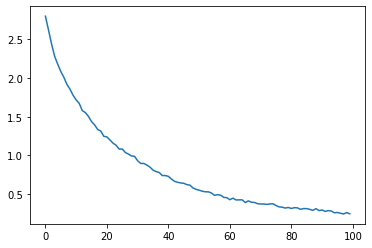

In [32]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

### Testing the model / Confusion matrix generation:
Evaluation is done on a new unused testing set

Using Testing Set (20%) of all data


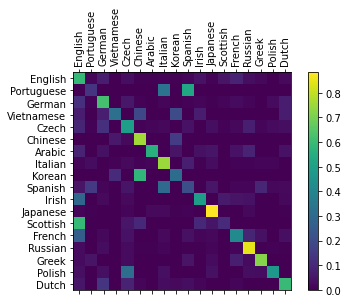

In [34]:
# Confusion Matrix: Rows are Categories | Columns are Guesses (this will show what are the guesses for each category)
lstm.train()
# 18 by 18 zero initiialztion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

trainingMode=0 # choose data from the testing set
if trainingMode==1:
  print("Using Training Set (80%) of all data")
else:
  print("Using Testing Set (20%) of all data")

# Just evaluate without backpropagation
def evaluate(batched_names, sequence_lengths):

    output = lstm(batched_names, sequence_lengths)

    return output

# Go through 10000 examples and record the result in the matrix
for i in range(n_confusion):

    # create a single batch
    names=[]
    nationalities=[]
    # the batch has names from different categories
    for i in range(batch_size):
      category, line = randomTrainingExample()
      while(category in nationalities): #not unqiue
        category, line = randomTrainingExample()
      
      # unique addition
      nationalities.append(category)
      names.append(line)
      

    # change the names to padded, get their lengths, get their target country names
    inputs, lengths,target_string=make_variables(names,nationalities)
    #print(target_string)

    # change the target country names to tensors
    target=create_target_tensor(target_string)
    #target=torch.LongTensor(target)

    output = evaluate(inputs,lengths)
    
    for i in range(batch_size):
      guess, guess_i = categoryFromOutput(output[i])
      category_i = target[i]
      confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

### Testing Accuracy:
Evaluation is done on a new unused testing set

In [36]:
# Driver code for the testing accuracy calculation:
trainingMode=0 # choose data from the testing set

if trainingMode==1:
  print("Using Training Set (80%) of all data")
else:
  print("Using Testing Set (20%) of all data")


iterations= 10000
correct_test=0
total_test=0

for i in range(iterations):
 # create a single batch sample
    names=[]
    nationalities=[]
    # the batch has names from different categories
    for i in range(batch_size):
      category, line = randomTrainingExample()
      while(category in nationalities): #not unqiue
        category, line = randomTrainingExample()
      
      # unique addition
      nationalities.append(category)
      names.append(line)
      

    # change the names to padded, get their lengths, get their target country names
    inputs, lengths,target_string=make_variables(names,nationalities)
    #print(target_string)

    # change the target country names to tensors
    target=create_target_tensor(target_string)

    with torch.no_grad():
      output = evaluate(inputs,lengths)


    for i in range(batch_size):
      _, guess_i = categoryFromOutput(output[i])
      category_i = target[i]
      if(guess_i==category_i):
        correct_test+=1
      total_test+=1

print(correct_test/total_test)

Using Testing Set (20%) of all data
0.5161875
